In [1]:
import pyspark

#### Start Spark cluster

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark =SparkSession.builder.getOrCreate()

In [4]:
spark = SparkSession.builder.appName('Practice').getOrCreate()

In [5]:
pyspark.__version__

'3.2.1'

In [6]:
spark

In [7]:
staticDataFrame = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("/MyProjects/Spark-The-Definitive-Guide/data/retail-data/by-day/*.csv")
staticDataFrame.createOrReplaceTempView("retail_data")
staticSchema = staticDataFrame.schema

In [8]:
staticDataFrame.show(20)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|
|   580538|    21544|SKULLS  WATER TRA...|      48|2011-12-05 08:38:00|     0.85|   14075.0|United Kingdom|
|   580538|    23126|FELTCRA

In [9]:
import pyspark.pandas as ps
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

In [10]:
psdf = staticDataFrame.to_pandas_on_spark()

####  Agg on customer total spending, invoice date window of 1 day,  get top 5 spender

In [11]:
staticDataFrame.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [12]:
from pyspark.sql.functions import window, column, desc, col
staticDataFrame.selectExpr("CustomerID","(UnitPrice * Quantity) AS Total_Cost","InvoiceDate")\
.groupby(
    col('CustomerID'), window(col('InvoiceDate'), "1 day"))\
.sum('total_cost')\
.show(5)

+----------+--------------------+-----------------+
|CustomerID|              window|  sum(total_cost)|
+----------+--------------------+-----------------+
|   16057.0|{2011-12-04 18:00...|            -37.6|
|   14126.0|{2011-11-28 18:00...|643.6300000000001|
|   13500.0|{2011-11-15 18:00...|497.9700000000001|
|   17160.0|{2011-11-07 18:00...|516.8499999999999|
|   15608.0|{2011-11-10 18:00...|            122.4|
+----------+--------------------+-----------------+
only showing top 5 rows



#####  Set partitions to 5

In [13]:
spark.conf.set('spark.sql.shuffle.partitions', 5)

#### K-means from Mlib

In [14]:
staticDataFrame.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [15]:
from pyspark.sql.functions import date_format, col

In [16]:
#DF with day of week
preppedDataFrame = staticDataFrame\
.na.fill(0)\
.withColumn('day_of_week', date_format(col('InvoiceDate'), 'EEEE'))\
.coalesce(5)

In [17]:
print(preppedDataFrame.show(5))
print(preppedDataFrame.select('day_of_week').distinct().show(10))

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|day_of_week|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|     Monday|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|     Monday|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|     Monday|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|     Monday|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|     Monday|
+---------+---------+-------------------

### Coalesce function


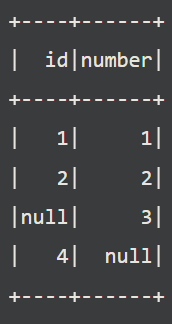
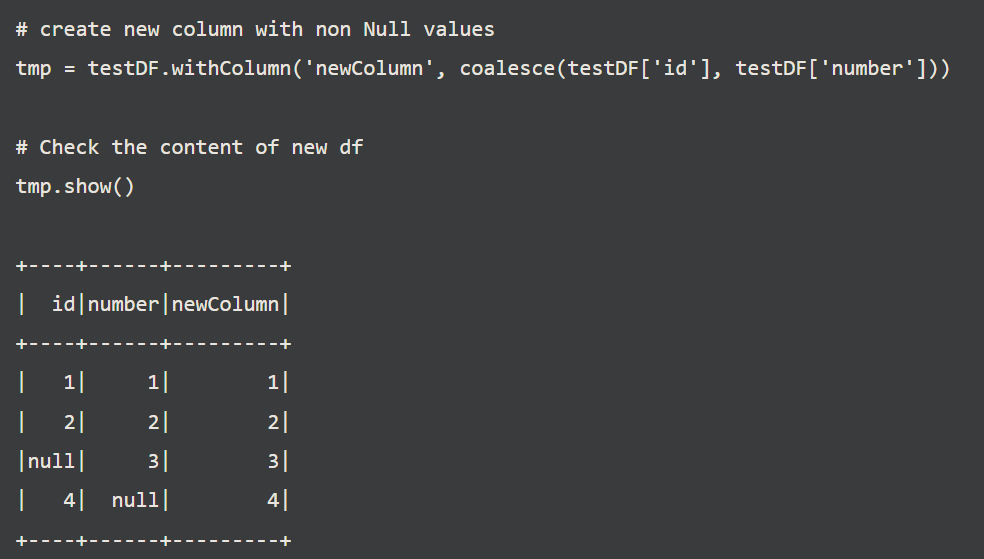

### Train Test Split (by Data only)

In [18]:
tranDataFrame = preppedDataFrame.where("InvoiceDate < '2011-07-01'")

In [19]:
testDataFrame =  preppedDataFrame.where("InvoiceDate >= '2011-07-01'")

In [20]:
print(f'Train df num: {tranDataFrame.count()}, Test df num: {testDataFrame.count()}')

Train df num: 245903, Test df num: 296006


#### As factor using string indexer

In [21]:
from pyspark.ml.feature import StringIndexer

In [22]:
indexer = StringIndexer()\
.setInputCol("day_of_week")\
.setOutputCol("day_of_week_index")

#### One hot encoding after string to numeric using indexer

In [23]:
from pyspark.ml.feature import OneHotEncoder

In [24]:
encoder = OneHotEncoder()\
.setInputCol("day_of_week_index")\
.setOutputCol("day_of_week_encoded")

#### Results in a set of columns we will assemble into a vector. Make all features into one feature
### Vector is the input type for Spark ml algorithm, which is a set of numeric value.

In [25]:
from pyspark.ml.feature import VectorAssembler

In [26]:
vectorAssembler = VectorAssembler()\
.setInputCols(["UnitPrice", "Quantity", "day_of_week_encoded"])\
.setOutputCol("features") 

### Build Pipeline
#### Stages
- fit transformers to the dataset (combine the tools above)
- 

In [27]:
from pyspark.ml import Pipeline

In [28]:
transformationPiepline = Pipeline()\
.setStages([indexer, encoder, vectorAssembler])

#### Spark needs to know how many unique values so it can index

In [29]:
fittedPipeline = transformationPiepline.fit(tranDataFrame)

#### Take the fitted pipeline and use it to transform all data

In [30]:
transformedTraning = fittedPipeline.transform(tranDataFrame)

In [31]:
#transformed dataframe
transformedTraning.to_pandas_on_spark().head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day_of_week,day_of_week_index,day_of_week_encoded,features
0,537226,22811,SET OF 6 T-LIGHTS CACTI,6,2010-12-06 08:34:00,2.95,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(2.95, 6.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
1,537226,21713,CITRONELLA CANDLE FLOWERPOT,8,2010-12-06 08:34:00,2.10,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(2.1, 8.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
2,537226,22927,GREEN GIANT GARDEN THERMOMETER,2,2010-12-06 08:34:00,5.95,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(5.95, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
3,537226,20802,SMALL GLASS SUNDAE DISH CLEAR,6,2010-12-06 08:34:00,1.65,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(1.65, 6.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
4,537226,22052,VINTAGE CARAVAN GIFT WRAP,25,2010-12-06 08:34:00,0.42,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.42, 25.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
5,537226,22705,WRAP GREEN PEARS,25,2010-12-06 08:34:00,0.42,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.42, 25.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
6,537226,20781,GOLD EAR MUFF HEADPHONES,2,2010-12-06 08:34:00,5.49,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(5.49, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
7,537226,22310,IVORY KNITTED MUG COSY,6,2010-12-06 08:34:00,1.65,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(1.65, 6.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
8,537226,22389,PAPERWEIGHT SAVE THE PLANET,6,2010-12-06 08:34:00,2.55,15987.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(2.55, 6.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
9,537227,22941,CHRISTMAS LIGHTS 10 REINDEER,2,2010-12-06 08:42:00,8.50,17677.0,United Kingdom,Monday,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(8.5, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0)"


#### Cache the dataframe to access it over and over again later

In [32]:
transformedTraning.cache()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string, day_of_week: string, day_of_week_index: double, day_of_week_encoded: vector, features: vector]

#### Train the model

### Naming pattern
- "Algorithm" is untrained version
- "Algorithm" Model is trained version


In [33]:
from pyspark.ml.clustering import KMeans

In [34]:
kmeans = KMeans()\
.setK(20)\
.setSeed(1)

In [35]:
transformedTraning.columns

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country',
 'day_of_week',
 'day_of_week_index',
 'day_of_week_encoded',
 'features']

In [36]:
kmModel = kmeans.fit(transformedTraning)

In [41]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()

evaluator.evaluate(kmModel)

AttributeError: 'KMeansModel' object has no attribute '_jdf'

In [42]:
spark.stop()